In [91]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import os
import sys
import time
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from pylab import rcParams
import itertools
import statsmodels.tsa.api as smt
from itertools import product
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9

In [153]:
# Load csv
train="C:\\Users\\admin\\Desktop\\Job Hunt Aus\\NationalBankPosition\\train.csv"
df_train = pd.read_csv(train, parse_dates=['start_time'], dayfirst=True)
df_train.head()
df_train.shape


,idx,start_time,end_time,var_w,var_t,var_bu,var_at,var_m,var_hl,var_hm,var_wd,others,cust,total_cnt
0,1,2011-01-01 00:00:00,1/01/2011 0:59,1000,119.68,0.0,68.79,17.0,0,40.5,0.0,3,13,16.0
1,2,2011-01-01 01:00:00,1/01/2011 1:59,1000,118.04,0.0,67.27,44.0,0,40.0,0.0,8,32,40.0
2,3,2011-01-01 02:00:00,1/01/2011 2:59,1000,118.04,0.0,67.27,NaN,0,40.0,0.0,5,27,32.0
3,4,2011-01-01 03:00:00,1/01/2011 3:59,1000,119.68,0.0,68.79,NaN,0,37.5,0.0,3,10,13.0
4,5,2011-01-01 04:00:00,1/01/2011 4:59,1000,119.68,0.0,68.79,NaN,0,37.5,0.0,0,1,1.0


(15919, 14)

In [154]:
# droping the unneccessary columns
cols = ['idx', 'end_time', 'var_w', 'var_t', 'var_bu', 'var_at', 'var_m', 'var_hl', 'var_hm', 'var_wd']
df_train.drop(cols, axis=1, inplace=True)
# df_train = df_train.sort_values('start_time')
# df_train.start_time = pd.to_datetime(df_train.start_time)
# df_train = df_train.sort_index()


In [155]:
# null values

# which columns have null value
df_train.isnull().sum()

# find null values
ind_row = pd.isnull(df_train).any(1).nonzero()[0]
ind_col = pd.isnull(df_train).any().nonzero()[0]
ind_col
ind_row

start_time    1
others        0
cust          0
total_cnt     1
dtype: int64

array([0, 3], dtype=int64)

array([11883, 14230], dtype=int64)

For the empty cell in start_time column, the date comes from the previouse cell, and the time also comes from the previouse cell, add by one unit.

In [156]:
# replace null values
for i in range(ind_col.size):
    if (ind_col[i]==0):
        df_train.iloc[ind_row[i], ind_col[i]] = df_train.iloc[ind_row[i-1], ind_col[i]] + pd.Timedelta(hours=1)
    else:
        dft = df_train.loc[df_train.start_time.dt.date == df_train.start_time.dt.date[ind_row[i]]]
        df_train.iloc[ind_row[i],ind_col[i]] = dft.iloc[:,ind_col[i]].mean()

# df_train.dropna(inplace=True)
# df_train.isnull().sum()

In [157]:
# show period
df_train['start_time'].min()
df_train['start_time'].max()
# df_train.iloc[-1,0]

Timestamp('2011-01-01 00:00:00')

Timestamp('2012-10-31 23:00:00')

In [158]:
# 'start_date' as index
df_train = df_train.set_index('start_time')

In [159]:
df_train['total_cnt'].describe()

count    15919.000000
mean       189.497320
std        182.008138
min          1.000000
25%         40.000000
50%        141.000000
75%        281.000000
max        977.000000
Name: total_cnt, dtype: float64

Above shows that the max value is much more than the mean while std is not that much big. If there are outliers, we might be  able to find from a plot. We try both daily-based and hourly-based transactions.

Text(0.5,1,'Hourly Data')

(<matplotlib.figure.Figure at 0x1e5b752ba90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e5bd72beb8>)

Text(0.5,1,'Daily Data')

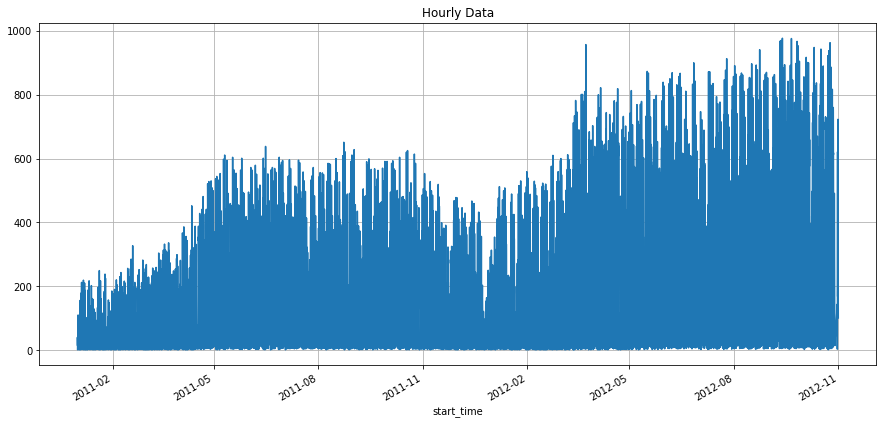

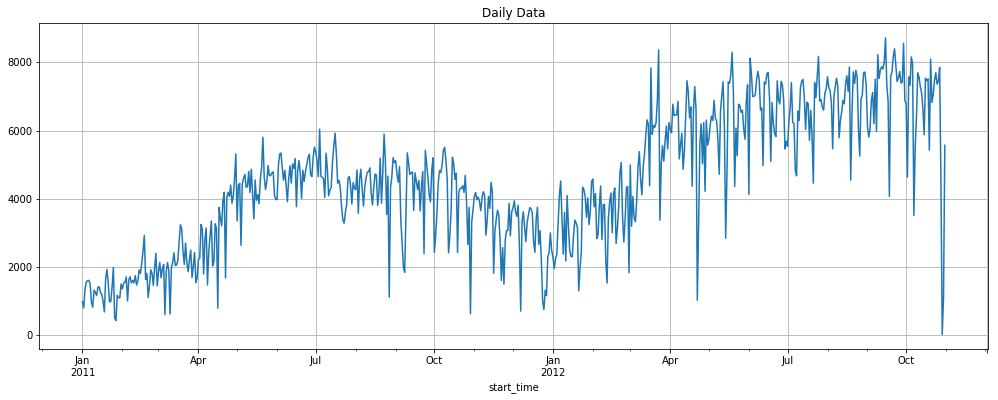

In [160]:
# time plots

#The frequency of a day
# ts.groupby(level=0).count()[:300]

# plot for hourly-based transactions
ts = df_train['total_cnt']
ts.plot(figsize=(15, 7))
plt.grid(True)
plt.title('Hourly Data')

# plot for daily-based transactions
ts2 = ts.resample('D').sum()
plt.figure(), ts2.plot(figsize=(17, 6))
plt.grid(True)
plt.title('Daily Data')

## Stationary Check
I opted two ways to check data stationary:
 - Using plotting the moving average or moving variance and see if the series mean and variance varies with time. 
 - Using a statistical test. Here we adopted the Dickey-Fuller Test. The null hypothesis for the test is that the time series is non-stationary. The test results compare a Test Statistic and Critical Values (cutoff value) at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

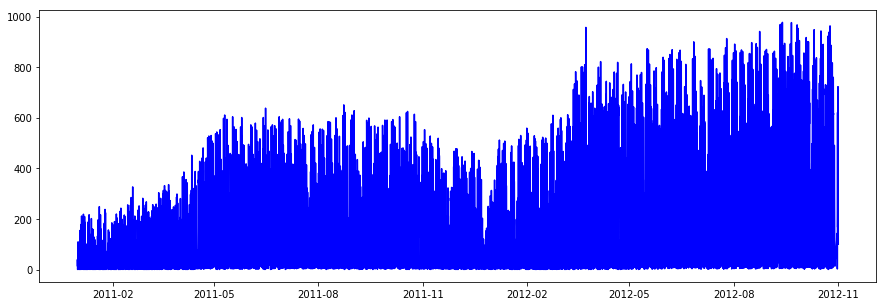

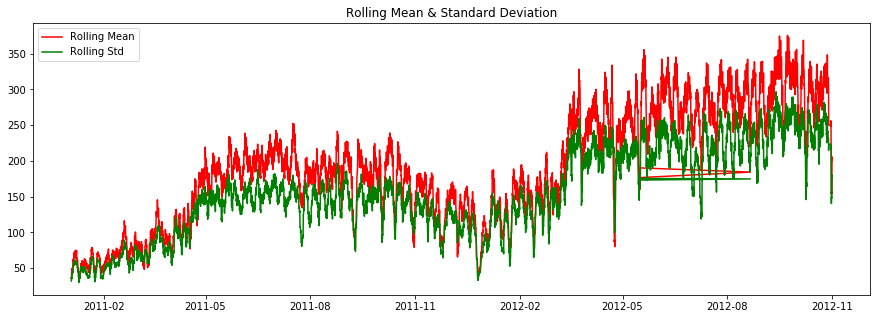

Results of Dickey-Fuller Test:
Test Statistic                -6.389946e+00
p-value                        2.118077e-08
#Lags Used                     4.300000e+01
Number of Observations Used    1.587500e+04
Critical Value (1%)           -3.430762e+00
Critical Value (5%)           -2.861722e+00
Critical Value (10%)          -2.566867e+00
dtype: float64


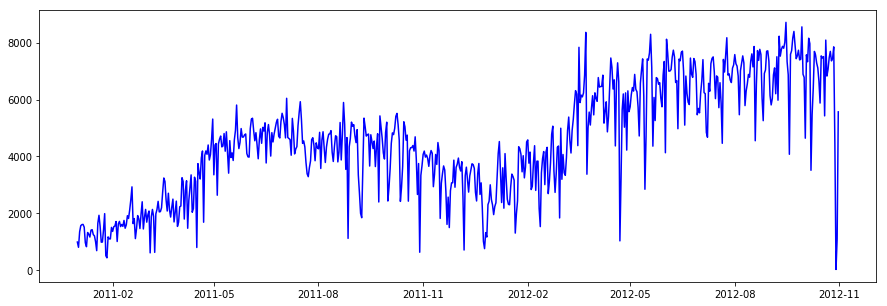

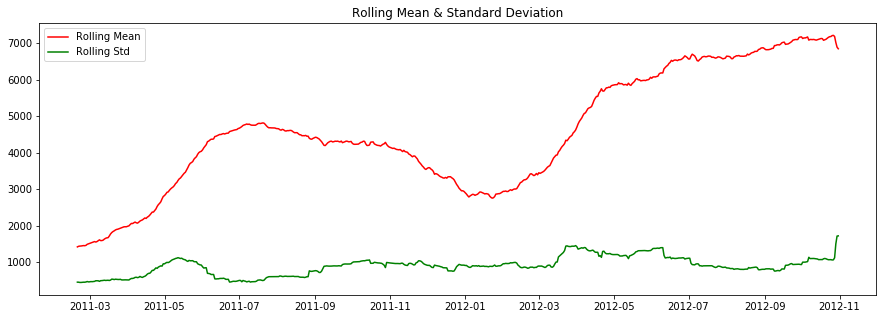

Results of Dickey-Fuller Test:
Test Statistic                  -1.869079
p-value                          0.346744
#Lags Used                      13.000000
Number of Observations Used    656.000000
Critical Value (1%)             -3.440358
Critical Value (5%)             -2.865956
Critical Value (10%)            -2.569122
dtype: float64


In [161]:
# stationary or non-statinary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):
    
    # define rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # plot rolling statistics
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    plt.figure(figsize=(15,5))
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# test using the hourly-based ts
test_stationarity(ts, 50)

# test using the daily-based ts
ts2 = ts.resample('D').sum()
test_stationarity(ts2, 50)

The hourly data suggests that the data is stationary given that Test Statistics is smaller than Critical Values, but the daily data suggests that mean and variance are changing over time. Therefore, It seems that our time series is stationary, but we need to make the data more statinary by Differencing or Decomposition.
 
Is the time series additive or multiplicative? In an additive time series, the components add together to make the time series. If you have an increasing trend, you still see roughly the same size peaks and troughs throughout the time series.
 

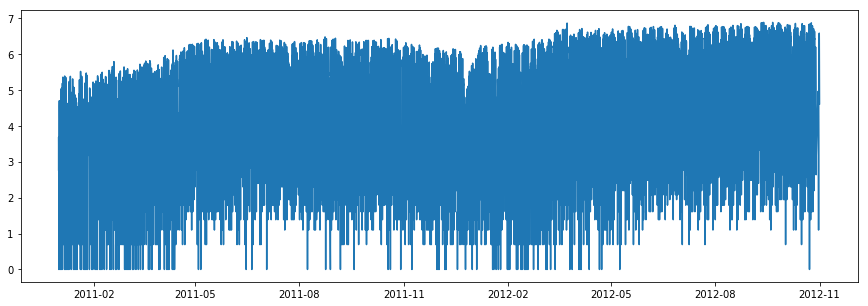

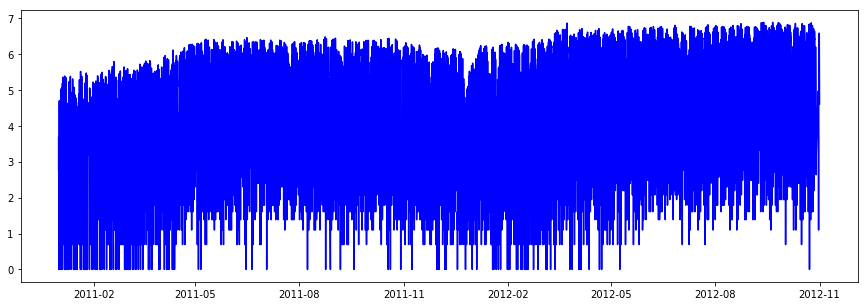

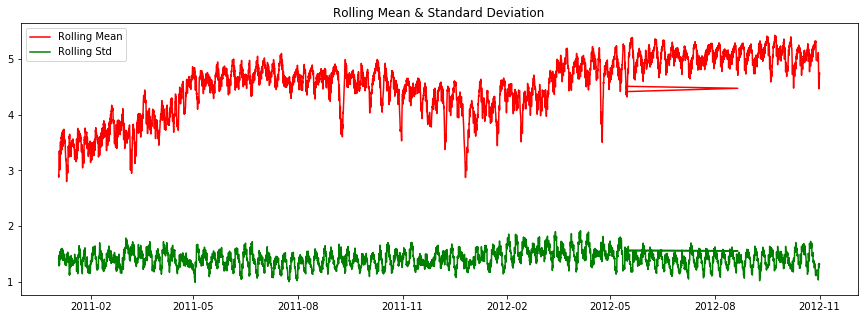

Results of Dickey-Fuller Test:
Test Statistic                -7.422507e+00
p-value                        6.678972e-11
#Lags Used                     4.100000e+01
Number of Observations Used    1.587700e+04
Critical Value (1%)           -3.430762e+00
Critical Value (5%)           -2.861722e+00
Critical Value (10%)          -2.566867e+00
dtype: float64


Text(0.5,1,'Moving average\n window size = 120')

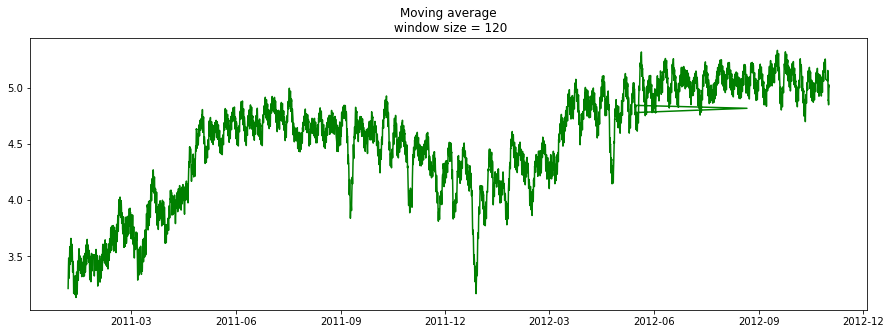

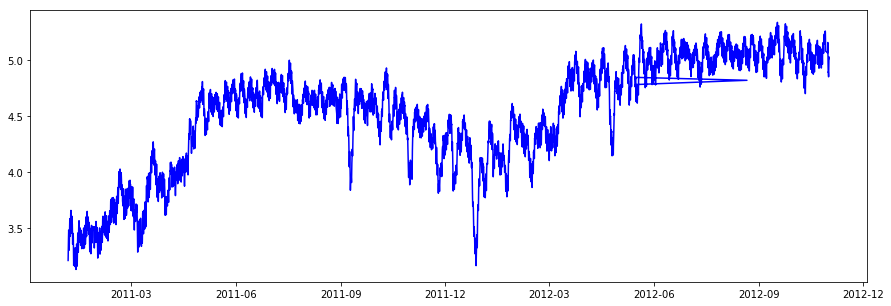

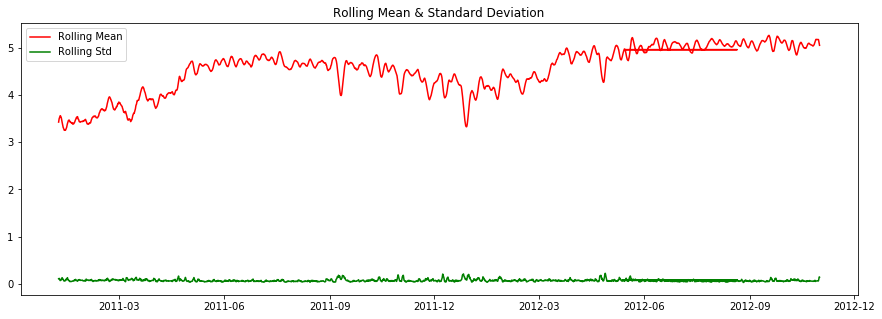

Results of Dickey-Fuller Test:
Test Statistic                    -3.255035
p-value                            0.017012
#Lags Used                        43.000000
Number of Observations Used    15776.000000
Critical Value (1%)               -3.430765
Critical Value (5%)               -2.861723
Critical Value (10%)              -2.566868
dtype: float64


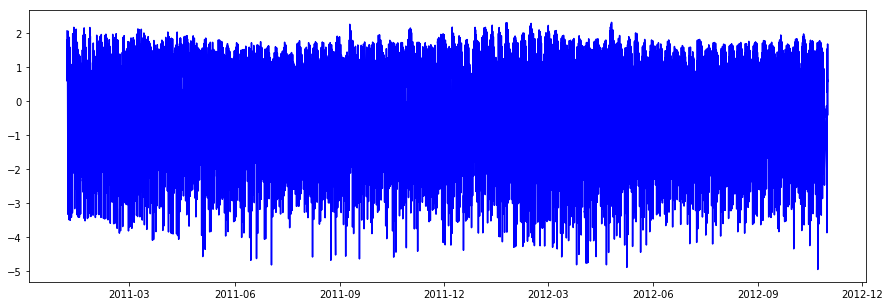

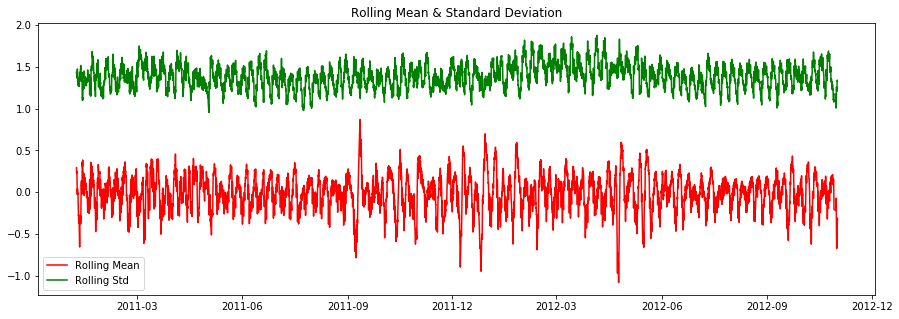

Results of Dickey-Fuller Test:
Test Statistic                   -18.841705
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15778.000000
Critical Value (1%)               -3.430765
Critical Value (5%)               -2.861723
Critical Value (10%)              -2.566868
dtype: float64


In [165]:
# log
ts_log = np.log(ts)
plt.figure(figsize=(15,5))
plt.plot(ts_log)
test_stationarity(ts_log, 50)

# mean of log
moving_avg = ts_log.rolling(100).mean()
plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(120))
plt.plot(moving_avg, "g", label="Rolling mean trend")

moving_avg.dropna(inplace=True)
test_stationarity(moving_avg, 50)

# difference of log and mean of log
ts_log_moving_avg_diff = ts_log - moving_avg
# ts_log_moving_avg_diff.head(120)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff, 50)

The last plot and Dickey-Fuller test clearly shows how the signal becomes more stationary.

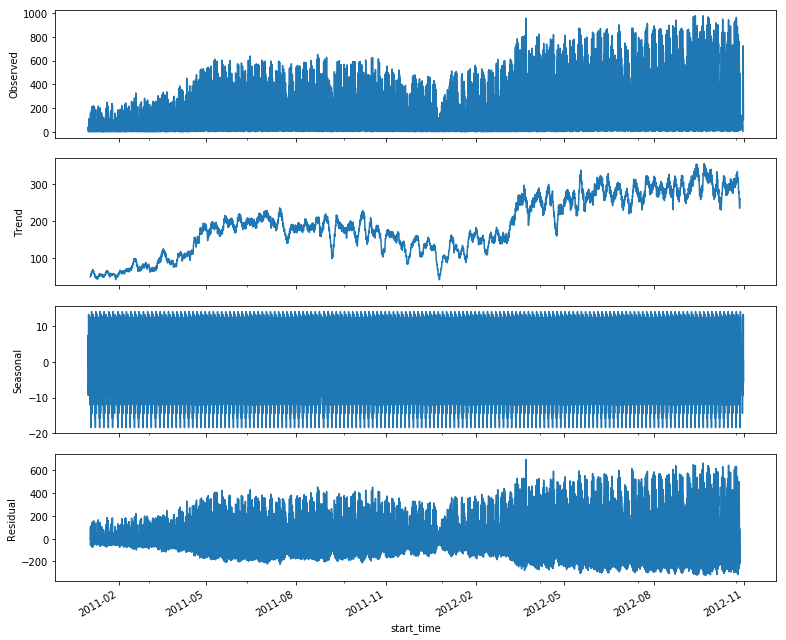

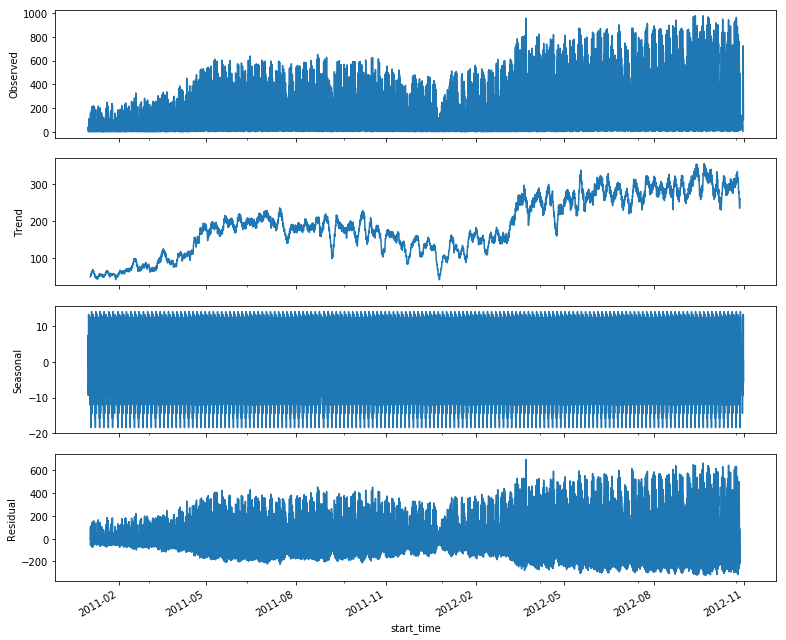

In [171]:
# hourly-based ts
decomposition = sm.tsa.seasonal_decompose(ts, model='additive',freq=100)
fig = decomposition.plot()
plt.show()

# daily-based ts
decomposition2 = sm.tsa.seasonal_decompose(ts2, model='additive',freq=100)
fig = decomposition.plot()
plt.show()

It seems that trend and seasonality are separated from data and it is good to model the residuals. Below is the stationarity test of residuals:

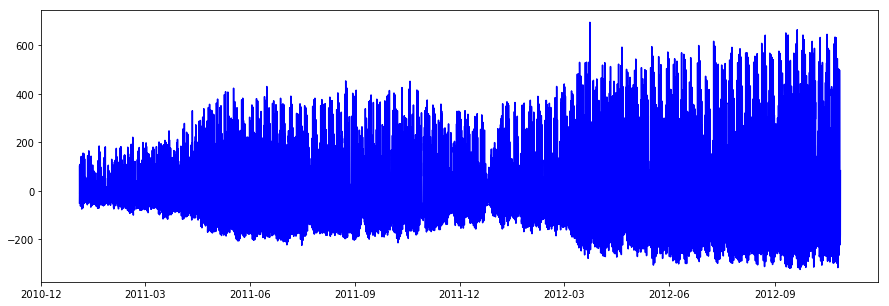

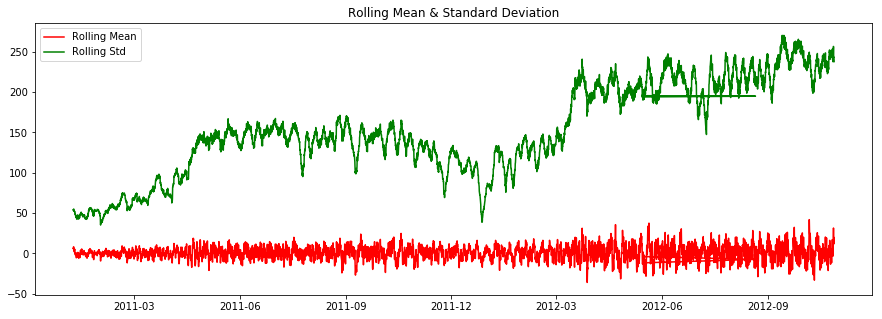

Results of Dickey-Fuller Test:
Test Statistic                   -27.287493
p-value                            0.000000
#Lags Used                        43.000000
Number of Observations Used    15775.000000
Critical Value (1%)               -3.430765
Critical Value (5%)               -2.861723
Critical Value (10%)              -2.566868
dtype: float64


In [174]:
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual, 100)

The Test Statistic is "too small", compared to the critical values. We can apply ARIMA or SARIMA to the residual or the original ts. Since there is no evidence of seasonality for the data, we can use ARIAMA.

# Prediction

To tune ARIMA parameters we can use one of the following approaches: 
 - ACF and PACF plots. 
 - A grid search
 
To make the grid search fast, we opt the p, d, and q to have a value of either 0 or 1. A better grid search would be to let them have values between 0 and 5. 

In [183]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:221078.5904045896
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:206451.29983617796
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:218671.6638416333
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:210180.85946200255
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:193893.02054823385
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:193510.0160929613
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:205112.25025182462
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:204005.03406942033
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:207919.0328738818
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:192056.9806016917
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:202393.9361438398
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:192199.61027538925
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:183129.95375055616
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:183015.76428230357
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:191771.37768178672
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:189570.92045140377
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:191457.04484561394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:186095.2203940081

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:191551.9733128973
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:191240.2791183396
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:204410.9389336354
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:188146.64387855452
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:190975.67107358406
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:188283.3791736549
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:180932.6353942326
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:180918.12570613658
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:188616.4644957806
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:188431.34148865944
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:200200.53252283722
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:184635.02824854353
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:188360.64603161102
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:184770.8781805475
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:179231.25436062017
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:179194.5580692429
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:190626.68442428677
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:190279.01278723282


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:182119.6879810395


The min AIC value is provided by:

    ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:179194.5580692429

In [218]:
# Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6107      0.005    131.284      0.000       0.602       0.620
ma.L1          0.3933      0.007     58.174      0.000       0.380       0.407
ar.S.L12      -0.8526      0.004   -213.376      0.000      -0.860      -0.845
ma.S.L12      -0.0628      0.010     -6.469      0.000      -0.082      -0.044
sigma2      4612.6231     27.851    165.617      0.000    4558.036    4667.210


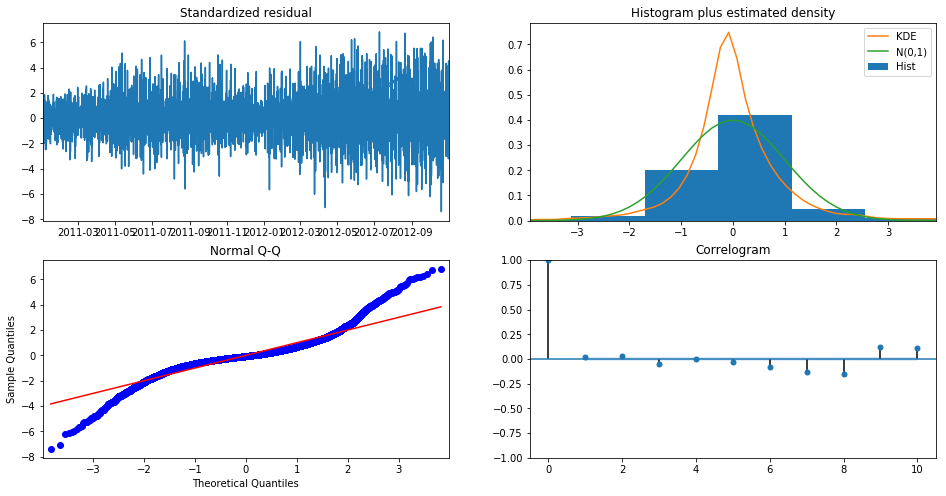

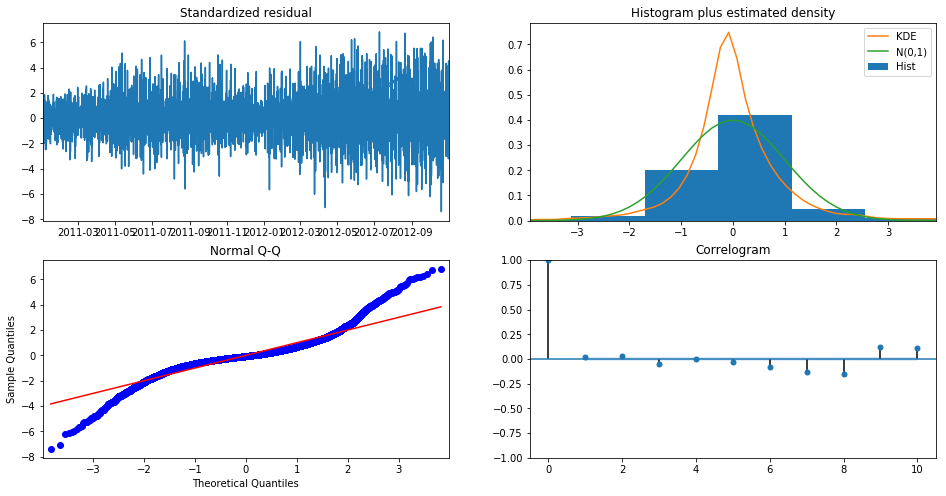

In [219]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [220]:
# load test data
test="C:\\Users\\admin\\Desktop\\Job Hunt Aus\\NationalBankPosition\\test.csv"
df_test = pd.read_csv(test, parse_dates=['start_time'], index_col='start_time', dayfirst=True)

cols = ['idx', 'end_time', 'var_w', 'var_t', 'var_bu', 'var_at', 'var_m', 'var_hl', 'var_hm', 'var_wd']
df_test.drop(cols, axis=1, inplace=True)

df_test.head()

# ts3 = df_test.total_cnt
# ts3.head()

""
start_time
2012-11-01 00:00:00
2012-11-01 01:00:00
2012-11-01 02:00:00
2012-11-01 03:00:00
2012-11-01 04:00:00


To have a sense of how the predictive model perform, we use a portion of the train dataset to predict: 

Text(0.5,0,'Start Date')

Text(0,0.5,'Totall Tranactions')

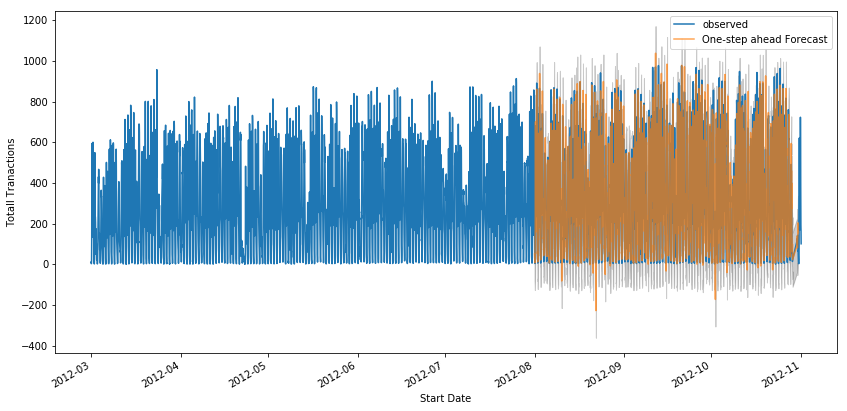

In [222]:
pred = results.get_prediction(start='2012-08-01', end='2012-10-31', dynamic=False)
pred_ci = pred.conf_int()

ts_t = pd.concat([ts, ts3])

ax = ts_t['2012-03-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Start Date')
ax.set_ylabel('Totall Tranactions')
plt.legend()
plt.show()

The above plot shows that the prediction is close to real data. 